# Homework #5. Exploratory Data Analysis
#### Author: `Michael Fediuchenko`
#### Total time spent on h/w (in minutes): `897`

## Data and libs import

In [1]:
import ast 
import datetime
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter1d 
import pandas as pd
import numpy as np
import nltk 
import re 

In [2]:
DIALOGS_MERGED_DATA_PATH = "data/merged_data/dialogs_data_all.csv" 
DIALOGS_META_MERGED_DATA_PATH = "data/merged_data/dialogs_users_all.csv"

In [3]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH)
df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH)

/var/folders/zb/3w6t_m957pq1wmf74sbzgkyc0000gq/T/ipykernel_2299/995574815.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DIALOGS_MERGED_DATA_PATH)


## Data pre-processing, Data cleanup

To make EDA more accurant I decided to do a pre-processing and analyze values 

#### df analyzing

In [4]:
df.index.size

2852525

In [5]:
# id
print(df[df.id.isna()].index.size)
df.groupby('id')['id'].count()

0


id
1          150
2          103
3           98
4          102
5          106
          ... 
2469015      1
2469016      1
2469019      1
2469024      1
2469029      1
Name: id, Length: 1582572, dtype: int64

In [6]:
# from_id
df[df.from_id.isna()].index.size

620922

In [7]:
# Make from_id: empty | PeerChannel | PeerUser
df.from_id = df.from_id.fillna('')
df.from_id.groupby(df.from_id.apply(lambda x: x[:8])).count()

from_id
             620922
PeerChan        420
PeerUser    2231183
Name: from_id, dtype: int64

In [8]:
# to_id
print(df[df.to_id.isna()].index.size)
df.to_id.groupby(df.to_id.apply(lambda x: str(type(x)))).count()

0


to_id
<class 'int'>     100013
<class 'str'>    2752512
Name: to_id, dtype: int64

In [9]:
# Make every row to has he same type of to_id
# So from_id: empty | PeerChannel | PeerUser
df.to_id = df.to_id.astype(str)

In [10]:
# fwd_from
print(df[df.fwd_from.isna()].index.size)
df.fwd_from = df.fwd_from.fillna('')
df[df.fwd_from != ''].fwd_from.iloc[0]

2776887


'MessageFwdHeader(date=datetime.datetime(2022, 11, 9, 20, 37, 28, tzinfo=datetime.timezone.utc), imported=False, from_id=PeerChannel(channel_id=1195589741), from_name=None, channel_post=450, post_author=None, saved_from_peer=None, saved_from_msg_id=None, psa_type=None)'

In [11]:
# message
df.message = df.message.fillna('')

In [12]:
# dialog_id
print(df[df.dialog_id.isna()].index.size)
df.dialog_id.dtype

0


dtype('int64')

In [13]:
# duration
print(df.groupby('type')['duration'].sum())
# is None for text type
print(df[df.duration.isna()].index.size == df[~df.type.isin(['video', 'voice'])].index.size)
# The longest and shortest duration 
max(df[df.duration.notna()].duration), min(df[df.duration.notna()].duration)

type
photo            0.0
sticker          0.0
text             0.0
video      4544815.0
voice       405584.0
Name: duration, dtype: float64
True


(12411.0, 0.0)

In [14]:
# type
print(df.type.value_counts())

text       2268067
photo       408888
video       104891
sticker      47071
voice        23608
Name: type, dtype: int64


In [15]:
# date
print(df[df.date.isna()].index.size)
print(df.loc[0, 'date'])
# convert data to more precessible format
df.date = df.date.apply(lambda d: datetime.datetime.strptime(d[:19], '%Y-%m-%d %H:%M:%S' ))
min(df["date"]), max(df["date"])

0
2022-11-04 20:48:11+00:00


(Timestamp('2015-11-01 21:40:16'), Timestamp('2022-12-07 22:14:40'))

In [16]:
# resulted df format
df.sample(10)

,id,date,from_id,to_id,fwd_from,message,type,duration,dialog_id
1940443,328740,2019-08-19 21:00:10,PeerUser(user_id=237066246),PeerChannel(channel_id=1124109395),,Ору,text,NaN,-1001124109395
1734034,539920,2020-12-09 22:50:54,PeerUser(user_id=780169597),PeerChannel(channel_id=1124109395),,втф летить на донбас,photo,NaN,-1001124109395
609932,1898779,2020-08-10 19:20:21,PeerUser(user_id=761250017),PeerChannel(channel_id=1188665251),,"🏙 День 1 \nСонце сходить, підсушуючи на тротуа...",video,5.0,-1001188665251
2620445,87638,2022-02-27 08:50:45,,PeerChannel(channel_id=1061098805),,Пресс-секретарь Зеленского о переговорах с Мос...,photo,NaN,-1001061098805
1759565,513867,2020-10-22 13:55:36,PeerUser(user_id=229463373),PeerChannel(channel_id=1124109395),,ніхуйово так ламали.,text,NaN,-1001124109395
1569084,810,2021-08-19 07:15:00,,PeerChannel(channel_id=1356582355),,"Цілковито підтримують — 4, більшість не визнач...",photo,NaN,-1001356582355
464358,2060596,2021-09-05 14:49:56,PeerUser(user_id=675094295),PeerChannel(channel_id=1188665251),,@rozovetskaya,text,NaN,-1001188665251
1178239,19717,2022-04-05 09:03:10,,PeerChannel(channel_id=1146954597),,,photo,NaN,-1001146954597
1820074,452192,2020-05-20 13:58:02,PeerUser(user_id=338892054),PeerChannel(channel_id=1124109395),,Спасибо,text,NaN,-1001124109395
222171,2324025,2022-01-13 10:13:41,PeerUser(user_id=543577315),PeerChannel(channel_id=1188665251),,Ми навряд будемо пересікатись,text,NaN,-1001188665251


#### df_meta analyzing

In [17]:
# df_meta
print(df_meta.index.size)

21929


In [18]:
# dialog_id
df_meta[df_meta.dialog_id.isna()].index.size

0

In [19]:
#name
df_meta[df_meta.name.isna()].index.size

0

In [20]:
# the most crowded and not groups
print(df_meta.groupby('name')['users'].count().sort_values(ascending=False).head(5))

name
DDOS атака на СЕПАРІВ (Кібер-Козаки)    8113
ВЕТПОМОЩЬ кошкам и собакам в беде       5684
Філіал КМЦ                              2560
Baraholka NaUKMA Chat                   1382
ФІ                                       817
Name: users, dtype: int64


In [21]:
print(df_meta.groupby('name')['users'].count().sort_values(ascending=True).head(5))

name
borsch            1
gloacademy_bot    1
d a w e e d       1
Соломія Сабат     1
borodaikevych     1
Name: users, dtype: int64


In [22]:
# type
# Amount of private dialogs and groups chats
df_meta[['dialog_id', 'type']].drop_duplicates().type.value_counts()

Private dialog    326
Group             120
Channel             5
Name: type, dtype: int64

In [23]:
#Amount of members in different types
df_meta.type.groupby(df_meta.type).count()

type
Channel               5
Group             21598
Private dialog      326
Name: type, dtype: int64

In [24]:
# users parsing 
print(df_meta.users.iloc[0])
users = df_meta.users.apply(ast.literal_eval)
users_col = lambda col: users.apply(lambda user: user[col])

for key in users.iloc[0]:
    df_meta[key] = users_col(key)
    
df_meta = df_meta.drop('users', axis=1)

{'user_id': 413172935, 'first_name': 'Helen)', 'last_name': None, 'username': 'ailiin_m', 'phone': '380983560647'}


In [25]:
# resulted df_meta
df_meta.sample(15)

,dialog_id,name,type,user_id,first_name,last_name,username,phone
6056,-1001601141641,DDOS атака на СЕПАРІВ (Кібер-Козаки),Group,516469551,Vic,None,viktor_sorokin0,None
16790,-1001614155281,ВЕТПОМОЩЬ кошкам и собакам в беде,Group,346614782,Андрей Ермаков,None,andrey17717,None
10052,-1001601141641,DDOS атака на СЕПАРІВ (Кібер-Козаки),Group,429106595,Alexey,None,alexey_105,None
15676,-1001614155281,ВЕТПОМОЩЬ кошкам и собакам в беде,Group,5290251828,Петя,Санич,PetjaSani4,None
14440,-1001614155281,ВЕТПОМОЩЬ кошкам и собакам в беде,Group,1050691247,Olga,None,KarOlha,None
13461,-1001124109395,Філіал КМЦ,Group,420691358,.,None,twoi_kotik,380661889946
7797,-1001601141641,DDOS атака на СЕПАРІВ (Кібер-Козаки),Group,472517516,Диана,None,diano4ka2106,None
12400,-1001124109395,Філіал КМЦ,Group,398467023,Vita,None,lipofrenichka,380674020824
10405,-1001497992208,Кентолянка Финансиста,Group,434774294,Evgeniy,Mikhno,jejek03,None
6179,-1001601141641,DDOS атака на СЕПАРІВ (Кібер-Козаки),Group,420511345,Руся,Алексеева,alekseevar,None


### EDA
Selected questions marked with ✅

##### ✅  1. The popularity of substrings during timeline

In [26]:
def word_usage(word):
    word_occur = df.message.apply(lambda m: m.count(word)).rename('wcount')
    res = pd.concat([df.date, word_occur], axis=1)
    return res

In [27]:
# Draw
def plot_line(x, y, xlabel=None, ylabel=None, title=None, colour='b'): 
    plt.plot(x, y, c=colour)
    if xlabel: 
        plt.xlabel(xlabel)
    if ylabel: 
        plt.ylabel(ylabel)
    if title: 
        plt.title(title)

In [28]:
# Thank's for my teammate (Taras Kreschenko) for help with this function
def plot_monthly_word_usage(word):
    usage = word_usage(word)
    yearmonth = usage.date.apply(lambda d: datetime.datetime.strptime(f'{d.month}/{d.year}', '%m/%Y'))
    usage_grouped = usage.wcount.groupby(yearmonth).sum() 
    usage_grouped.drop(usage_grouped.index.max(), inplace=True)
    
    smooth = gaussian_filter1d(usage_grouped, sigma=2)
    plot_line(x=usage_grouped.index, y=usage_grouped.values,
    xlabel='Date',
    ylabel='Monthly occurrences', title=f'Substring usage "{word}" per month', colour='#1f77b4')
    plot_line(x=usage_grouped.index, y=smooth) 
    plt.show()

✅  1.1 How the usage of substring "війна" was changing in period?

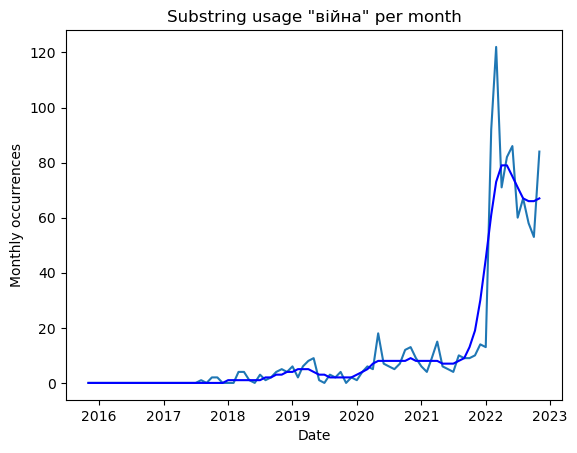

In [29]:
plot_monthly_word_usage('війна')

There is an increase in using substring "війна" after full-scale russian invasion. 
If to analyze chart that there were some usages of this substring between 2020 and 2021 and than 3-4 monthes before full-scale invasion

✅  1.2 How the usage of substring "діти" was changing in period?

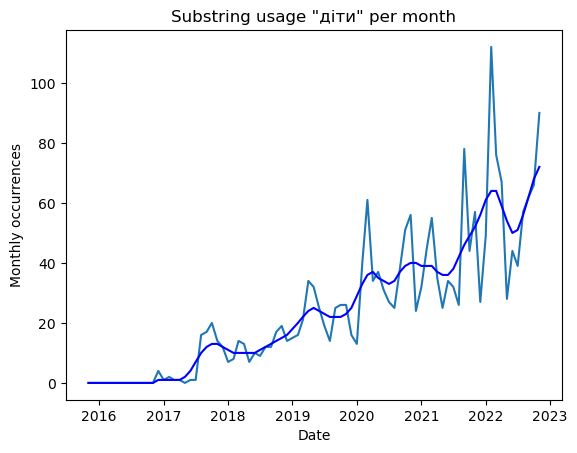

In [30]:
plot_monthly_word_usage('діти')

There is an increase in using substring "діти" after full-scale russian invasion. 
But even before this about 5 messages pre month we had.

1.3 How the usage of substring "Порошенко" was changing in period?

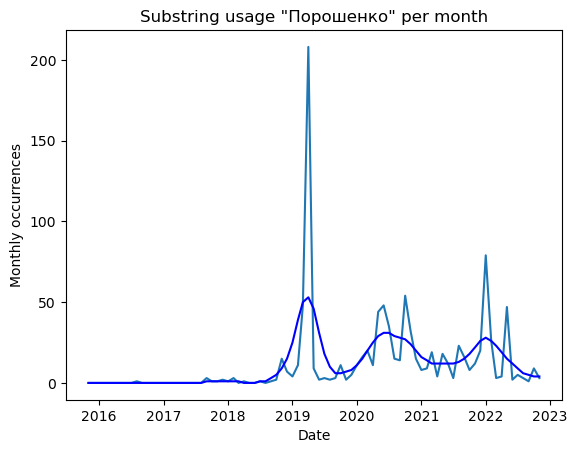

In [31]:
plot_monthly_word_usage('Порошенко')

There is an increase in using substring "Порошенко" during president election in Ukraine than it decreased and increased etween 2020-2021 and in 2022 years.

1.3 How the usage of substring "Зеленський" was changing in period?

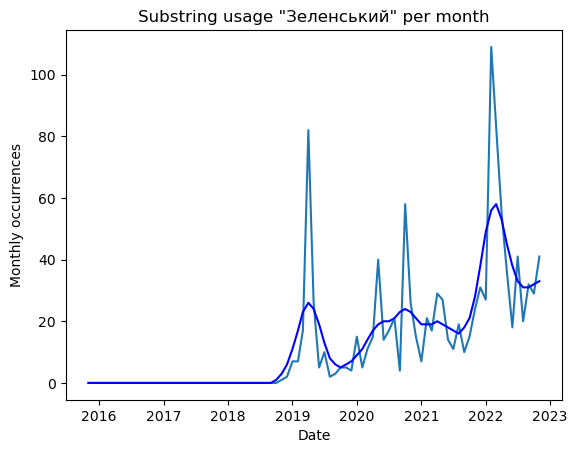

In [32]:
plot_monthly_word_usage('Зеленський')

There is an increase in using substring "Зеленський" during president election in Ukraine and parlament elections and after full-scale invasion of ruzzhists in Ukraine it increased rapidly. .

###### ✅  2. What is the top 10 first names and lastnames? 

In [33]:
# First of all need get users from `df_meta` 
df_users = df_meta[['user_id', 'first_name', 'last_name', 'username', 'phone']].drop_duplicates().set_index('user_id') 
df_users.first_name.value_counts().head(10)

Anna          152
Alex          123
Oleksandr     100
Roman          94
Andrii         87
Vlad           84
Anastasiia     83
Dmytro         83
Daria          76
Ivan           76
Name: first_name, dtype: int64

In [34]:
df_users.last_name.value_counts().head(10)

K     56
S     41
M     33
🇺🇦    26
D     25
.     23
R     18
B     17
L     17
✙     17
Name: last_name, dtype: int64

The most popular woman name in my Telegram is Anna and man name Alex and it's synonym Oleksandr. 
The surname that begins on `K`. Interesting that on 4-th place is Ukrainian flag

###### ✅  3.  Is there a change in the number of voice messages people are sending?

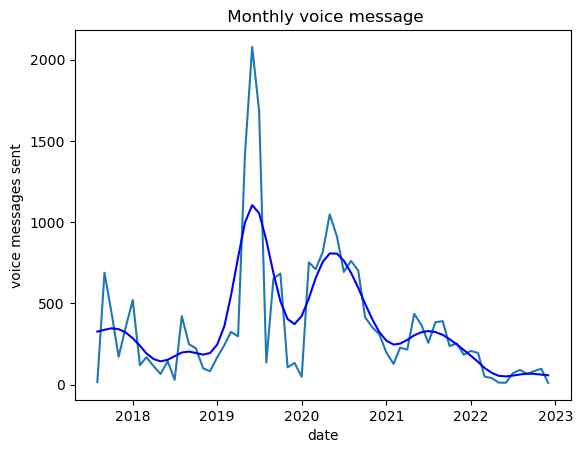

In [35]:
voice_yearmonth = df[df.type == 'voice'].date.apply(lambda d: datetime.datetime.strptime(f'{d.month}/{d.year}', '%m/%Y'))
voice_grouped = voice_yearmonth.value_counts().sort_index() 
plot_line(x=voice_grouped.index,
                y=voice_grouped.values,
                xlabel='date',
                ylabel='voice messages sent',
                title=' Monthly voice message', colour='#1f77b4')
smooth = gaussian_filter1d(voice_grouped, sigma=2) 
plot_line(x=voice_grouped.index, y=smooth)
plt.show()

The usage of voice messages decreased almost to 0 in last 2 years

##### ✅  4.How many bots were used and what is the top 5 most used bot by me?  

In [36]:
bots = df_users[df_users.username.str.lower().str.contains('bot') & df_users.last_name.isna()] 
bots

,first_name,last_name,username,phone
user_id,,,,
546182150,Бонус Плюс,None,BonusPlusBot,None
200942125,Controller Bot,None,ControllerBot,None
260776413,Кінотеатр «Україна»,None,kinoUkraine_bot,None
527518987,Comments Bot,None,CommentsBot,None
1039251874,ДТЕК Київські електромережі,None,DTEKKyivskielectromerezhibot,None
...,...,...,...,...
389338801,Anhelina,None,verbotenus,None
414303323,Pimp Slapper,None,pimpslapperbot,None
1358123622,Support Kyiv Parking,None,ParkingKyivBot,None


In [37]:
top_bots = df[df.dialog_id.isin(bots.index)].dialog_id.value_counts().head(5)
print(top_bots)
df_users[df_users.index.isin(top_bots.index)]

430091003     3472
5094614423     745
318623145      693
219520606      376
463299080      199
Name: dialog_id, dtype: int64


,first_name,last_name,username,phone
user_id,,,,
430091003,KMAScheduler,None,KMASchedulerBot,None
219520606,Zenmoney Bot,None,zenmoneybot,None
463299080,BZD • Бот • Книги по программированию,None,Bzdnbot,None
318623145,Tproger Bot,None,tproger_official_bot,None
5094614423,"Оренда квартир, кімнат, будинків України",None,good_rent_bot,None


The list of my top used bots consist if 40% KMA bots and 40% money-budget management bots, 20% usage of Telegram's `BotFather`

##### ✅  5. How different is amount of voice messages in dialogs, channels, and group channels?


In [38]:
# Create df for dialogs
df_dialogs = df_meta[['dialog_id', 'name', 'type']].drop_duplicates().set_index('dialog_id')

# Help functions 
def _id_to_col(_id, col_name, default=''): 
    if _id.startswith('PeerUser'):
        _id_int = int(_id[17:-1])
        return df_users[col_name].get(_id_int, default) 
    else:
        return default
    
def d_id_to_col(_id, col_name, default=''): 
    return df_dialogs[col_name].get(_id, default)

##### Datasets merging:

In [39]:
# Join dfs to have consistent data

df_combined = df.copy(deep=False)
df_combined['_first_name'] = df.from_id.apply(lambda _id: _id_to_col(_id , 'first_name'))
df_combined['_last_name'] = df.from_id.apply(lambda _id: _id_to_col(_id, 'last_name'))
df_combined['_username'] = df.from_id.apply(lambda _id: _id_to_col(_id, 'username'))
df_combined['_phone'] = df.from_id.apply(lambda _id: _id_to_col(_id, 'phone'))
df_combined['dialog_name'] = df.dialog_id.apply(lambda _id: d_id_to_col(_id, 'name'))
df_combined['dialog_type'] = df.dialog_id.apply(lambda _id: d_id_to_col(_id, 'type'))

In [40]:
private_dia_counts = df_combined[(df_combined.dialog_type == 'Private dialog') & (df_combined.type == 'voice')].dialog_id.value_counts().values
group_dia_counts = df_combined[(df_combined.dialog_type == 'Group') & (df_combined.type == 'voice')].dialog_id.value_counts().values

other_dia_counts = df_combined[(df_combined.dialog_name == '') & (df_combined.type == 'voice')].dialog_id.value_counts().values

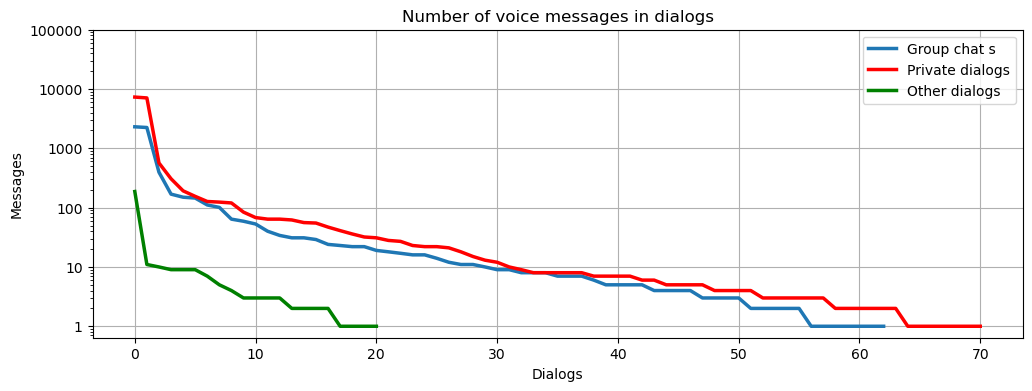

In [41]:
plt.subplots(figsize=(12,4))
plt.plot(range(group_dia_counts.size), group_dia_counts, linewidth=2.5, label='Group chat s')
plt.plot(range(private_dia_counts.size), private_dia_counts, c='r', linewidth=2.5, label= 'Private dialogs')
plt.plot(range(other_dia_counts.size), other_dia_counts, c='g', linewidth=2.5, label='Other dialogs')
plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000, 100000], [1, 10, 100, 1000, 10000, 100000]) 
plt.ylabel('Messages')
plt.xlabel('Dialogs')
plt.title('Number of voice messages in dialogs')
plt.legend()
plt.grid()
plt.show()

That's interesting that popularity of voice messages usage is higher in private dialogs, I think that is because of people's shyness. I have 1-2 private dialogs that has more than 120 voice messages.

#####  6. What is the trend of my text messages, voice messages and media content interraction in Telegram?  

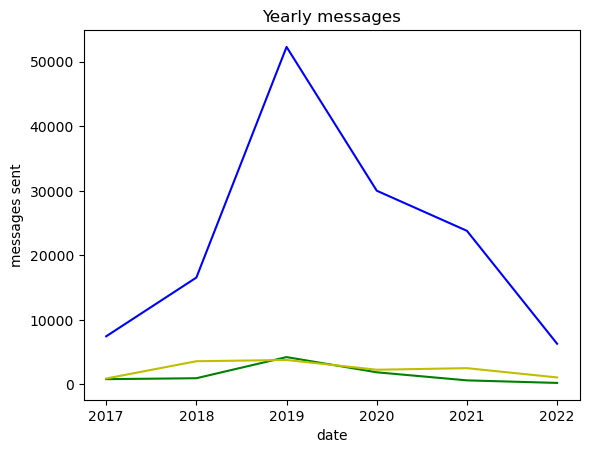

In [42]:
text_messages_yearly = df_combined[(df_combined._username == "MikLay") & (df_combined.type == "text")].date.apply(lambda d: d.year) 
text_messages_grouped = text_messages_yearly.value_counts().sort_index()

voice_messages_yearly = df_combined[(df_combined._username == "MikLay") & (df_combined.type == "voice")].date.apply(lambda d: d.year) 
voice_messages_grouped = voice_messages_yearly.value_counts().sort_index()

media_messages_yearly = df_combined[(df_combined._username == "MikLay") & ((df_combined.type == "photo") | (df_combined.type == "video") | (df_combined.type == "sticker"))].date.apply(lambda d: d.year) 
media_messages_grouped = media_messages_yearly.value_counts().sort_index()

plot_line(x=text_messages_grouped.index, 
                y=text_messages_grouped.values,
                xlabel='date', 
                ylabel='messages sent', 
                title='Yearly messages')
plot_line(x=voice_messages_grouped.index, 
                y=voice_messages_grouped.values, colour='g')

plot_line(x=media_messages_grouped.index, 
                y=media_messages_grouped.values, colour='y')


My activity in Telegram decreased after 2019, hah that is interesting that in 2019 I have found my first job

##### ✅  7. What is the trend of overall text messages, voice messages and media content usage in Telegram?  

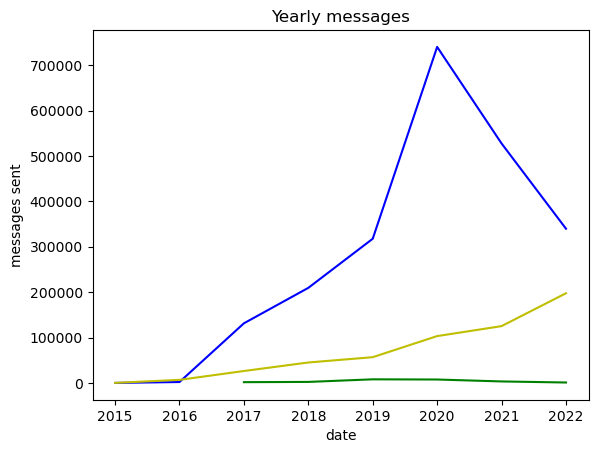

In [43]:
text_messages_yearly = df_combined[(df_combined.type == "text")].date.apply(lambda d: d.year) 
text_messages_grouped = text_messages_yearly.value_counts().sort_index()

voice_messages_yearly = df_combined[(df_combined.type == "voice")].date.apply(lambda d: d.year) 
voice_messages_grouped = voice_messages_yearly.value_counts().sort_index()

media_messages_yearly = df_combined[(df_combined.type == "photo") | (df_combined.type == "video") | (df_combined.type == "sticker")].date.apply(lambda d: d.year) 
media_messages_grouped = media_messages_yearly.value_counts().sort_index()

plot_line(x=text_messages_grouped.index, 
                y=text_messages_grouped.values,
                xlabel='date', 
                ylabel='messages sent', 
                title='Yearly messages')
plot_line(x=voice_messages_grouped.index, 
                y=voice_messages_grouped.values, colour='g')
plot_line(x=media_messages_grouped.index, 
                y=media_messages_grouped.values, colour='y')

People activity in chats show interesting result: after 2020 amount of text messages started decreasing, as well as media content, but in 2021 we see rapid increase in amount of media content in telegram. 

✅ 8. What is the top 10 private dialogs where I wrote the most messages? 

In [44]:
top_private_dialogs = df_combined[(df_combined.dialog_type == 'Private dialog') & (df_combined._username == "MikLay")].groupby('dialog_name')['dialog_id'].count().reset_index(name='amount').sort_values(by=['amount'], ascending=False).head(10)
top_private_dialogs


,dialog_name,amount
240,Ліза Мороз,53053
252,Моє Коханнячко,39679
192,Антон Рябоконь,6710
231,Катя Шекета,6443
181,Ілюха,4397
241,Мама,3387
208,Владик Жулкевский,2552
136,Taras Kreshchenko,2481
68,KMAScheduler,1676
251,Миша,1223


That was interesting to see that there are people with whom I had a lot of messages from my side.

---

# Homework #6. Improve behaviour exploration
#### Author: `Michael Fediuchenko`
#### Total time spent on h/w (in minutes): `732`

In [45]:
import re

In [46]:
# Female names
DICT_F_T_NAMES = "./tone-dict-ukrainian/dicts/female_ru_ukr_trans_names.csv"
DICT_F_U_NAMES = "./tone-dict-ukrainian/dicts/female_ukrainian_names.csv"
DICT_F_R_NAMES = "./tone-dict-ukrainian/dicts/female_russian_names.csv"

# Male names
DICT_M_T_NAMES = "./tone-dict-ukrainian/dicts/male_ru_ukr_trans_names.csv"
DICT_M_U_NAMES = "./tone-dict-ukrainian/dicts/male_ukrainian_names.csv"
DICT_M_R_NAMES = "./tone-dict-ukrainian/dicts/male_russian_names.csv"

# New names
DICT_NEW_F_NAMES = './new_female_names.csv'
DICT_NEW_M_NAMES = './new_male_names.csv'

#### Female and Male names processing 
I found out that provided datasets were not perfectly mapped to each other so I made clean-up and organized names
##### Female

In [47]:
df_female_transcript_names = pd.read_csv(DICT_F_T_NAMES)
df_female_ukrainian_names = pd.read_csv(DICT_F_U_NAMES)
df_female_russian_names = pd.read_csv(DICT_F_R_NAMES)

In [48]:
# Fixing transcript for Ukrainian female names
df_female_t_names = df_female_transcript_names[1798:].reset_index(drop=True)

# Missed names
df_female_missed_t_names1 = pd.DataFrame({"name": "Nelya"}, index=[188])
df_female_missed_t_names2 = pd.DataFrame({"name": "Mylausha"}, index=[205])
df_female_missed_t_names3 = pd.DataFrame({"name": "Ruzilya"}, index=[300])
df_female_missed_t_names4 = pd.DataFrame({"name": "Tatiyana"}, index=[501])
df_female_missed_t_names5 = pd.DataFrame({"name": "Nika"}, index=[604])
df_female_missed_t_names6 = pd.DataFrame({"name": "Kalyna"}, index=[739])
df_female_missed_t_names7 = pd.DataFrame({"name": "Sevda"}, index=[755])

df_female_t_names = pd.concat([df_female_t_names[:188], df_female_missed_t_names1, df_female_t_names[188:204],df_female_missed_t_names2,df_female_t_names[204:299],df_female_missed_t_names3,df_female_t_names[299:498], df_female_missed_t_names4 ,df_female_t_names[498:604], df_female_missed_t_names5 ,df_female_t_names[604:734], df_female_missed_t_names6 ,df_female_t_names[734:749], df_female_missed_t_names7 ,df_female_t_names[749:1448],df_female_t_names[1449:1633],df_female_t_names[1634:]]).rename(columns={'name':'t_name'}).reset_index(drop=True)

df_female_ukr_t_names = pd.concat([df_female_ukrainian_names, df_female_t_names], axis=1).reset_index(drop=True)

df_female_ukr_t_names[10:]

,name,t_name
10,валентина,valentine
11,людмила,ludmyla
12,галина,branch
13,ніна,Nina
14,катерина,Catherine
...,...,...
1793,Ернестіна,Ernestine
1794,Есмеральда,Esmeralda
1795,Юліанія,Juliana
1796,юнія,June


In [49]:
# Fixing transcript for r@ female names
df_ru_matched_t_names = df_female_transcript_names[:1798].reset_index(drop=True)
df_female_missed_t_names = pd.DataFrame({"name": "andreya"}, index=[1455])
df_ru_matched_t_names = pd.concat([df_ru_matched_t_names[:1454], df_female_missed_t_names, df_ru_matched_t_names[1454:]]).rename(columns={'name':'t_name'}).reset_index(drop=True)
df_female_ru_t_names = pd.concat([df_female_russian_names, df_ru_matched_t_names], axis=1).reset_index(drop=True)
df_female_ru_t_names[10:]

,name,t_name
10,галина,galina
11,нина,Nina
12,екатерина,Ekaterina
13,надежда,hope
14,александра,Alexandra
...,...,...
1794,эрнестина,ernestina
1795,эсмеральда,esmeralda
1796,юлиания,Juliania
1797,юния,Junia


In [50]:
df_female_ukr_or_ru_t_names = pd.concat([df_female_ukr_t_names,df_female_ru_t_names]).drop_duplicates().reset_index(drop=True)
df_female_ukr_or_ru_t_names[10:]

,name,t_name
10,валентина,valentine
11,людмила,ludmyla
12,галина,branch
13,ніна,Nina
14,катерина,Catherine
...,...,...
3382,эрнестина,ernestina
3383,эсмеральда,esmeralda
3384,юлиания,Juliania
3385,юния,Junia


##### Male

In [51]:
df_male_transcript_names = pd.read_csv(DICT_M_T_NAMES)
df_male_ukrainian_names = pd.read_csv(DICT_M_U_NAMES)
df_male_russian_names = pd.read_csv(DICT_M_R_NAMES)

In [52]:
# Fixing transcript for Ukrainian male names
df_male_t_names = df_male_transcript_names[3331:].rename(columns={'name':'t_name'}).reset_index(drop=True)
df_male_t_names = pd.concat([df_male_t_names, pd.DataFrame({'t_name': 'yaropolk'}, index=[3331])])
df_male_ukrainian_names = df_male_ukrainian_names.drop([422,1226,1864,2549]).reset_index(drop=True)

df_male_ukr_t_names = pd.concat([df_male_ukrainian_names, df_male_t_names], axis=1).reset_index(drop=True)
df_male_ukr_t_names[0:]

,name,t_name
0,олександр,Alexander
1,Микола,Mykola
2,іван,Ivan
3,Сергій,Sergii
4,владимир,Vladimir
...,...,...
3327,Хрисанф,Chrysanth
3328,Еразм,Erasmus
3329,Юстиніан,Justinian
3330,січень,January


In [53]:
# Fixing transcript for r@ male names
df_ru_matched_t_names = df_male_transcript_names[:3331].reset_index(drop=True)
df_female_missed_t_names = pd.DataFrame({"name": "famil"}, index=[2545])
df_ru_matched_t_names = pd.concat([df_ru_matched_t_names[:2545], df_female_missed_t_names, df_ru_matched_t_names[2545:]]).rename(columns={'name':'t_name'}).reset_index(drop=True)
df_male_ru_t_names = pd.concat([df_male_russian_names, df_ru_matched_t_names], axis=1).reset_index(drop=True)
df_male_ru_t_names[0:]

,name,t_name
0,александр,Alexander
1,николай,nicholas
2,иван,ivan
3,сергей,Sergei
4,владимир,vladimir
...,...,...
3327,хрисанф,chrysanthus
3328,эразм,Erasmus
3329,юстиниан,justinian
3330,януарий,januarium


In [54]:
df_male_ukr_or_ru_t_names = pd.concat([df_male_ukr_t_names,df_male_ru_t_names]).drop_duplicates().reset_index(drop=True)
df_male_ukr_or_ru_t_names[0:]

,name,t_name
0,олександр,Alexander
1,Микола,Mykola
2,іван,Ivan
3,Сергій,Sergii
4,владимир,Vladimir
...,...,...
6227,хрисанф,chrysanthus
6228,эразм,Erasmus
6229,юстиниан,justinian
6230,януарий,januarium


##### All names

In [55]:
df_all_names = pd.concat([df_male_transcript_names,df_male_russian_names,df_male_ukrainian_names,df_female_transcript_names,df_female_russian_names,df_female_ukrainian_names]).reset_index(drop=True)
df_all_names['name'] = df_all_names.name.str.lower()
df_all_names


,name
0,alexander
1,nicholas
2,ivan
3,sergei
4,vladimir
...,...
20509,ернестіна
20510,есмеральда
20511,юліанія
20512,юнія


Than I investigated users dataset. I noticed that some usernames have non alpha chars, emojis, extra spaces. So I decided to format and clean first_name column.

In [56]:
# formatting first_name
def format_first_name(first_name):
    if first_name is None:
        return ''
    formatted_first_name = re.sub(r'[^\sA-Za-zА-Яа-яЄєІіЇїҐґ]',' ', first_name)
    formatted_first_name = re.sub(r'\s+',' ',formatted_first_name)
    formatted_first_name = formatted_first_name.strip()
    formatted_first_name = formatted_first_name.lower()
    return formatted_first_name

In [57]:
df_users['formatted_first_name'] = df_users.apply(lambda row: format_first_name(row.first_name), axis=1)
len(df_users.formatted_first_name.index)

18086

Looking for the most popular names that are not in the list

In [58]:
missing_names_groups = df_users[~df_users.formatted_first_name.isin(df_all_names.name)].formatted_first_name.value_counts()
missing_names_groups.index

Index(['', 'oleksandr', 'roman', 'anastasiia', 'andrii', 'dima', 'kateryna',
       'kate', 'vladyslav', 'serhii',
       ...
       'rapunzel', 'orion', 'qjumperq', 'john doe', 'tasiya', 'стефано',
       'hibernate', 'таисавто', 'xantaress', 'запис даних'],
      dtype='object', length=5818)

I decided to write small program to fastly assign manually sex of the name's owner

In [59]:
def assign_names(names): 
    new_female_names = []
    new_male_names = []
    print("Please select \n'm' for male; \n'f' for female\n'n' for none\n'exit' to stop")
    for name in names:
#         name_sex = cv2.waitKey(0) & 0xFF
        name_sex = str(input(f'"{name}"\n'))
        if name_sex == 'f':
                new_female_names.append(name)
        elif name_sex == 'm':
                new_male_names.append(name)
        elif name_sex == 'n':
                continue
        elif name_sex == 'exit':
                break
    
    return new_female_names, new_male_names

In [60]:
# new_female_names, new_male_names =  assign_names(missing_names_groups.index.tolist())

In [61]:
# df_new_female_names = pd.DataFrame({'name':new_female_names})
# df_new_male_names = pd.DataFrame({'name':new_male_names})

In [62]:
# df_new_female_names.to_csv(path_or_buf=DICT_NEW_F_NAMES, index=False)
# df_new_male_names.to_csv(path_or_buf=DICT_NEW_M_NAMES, index=False)

In [63]:
df_new_female_names = pd.read_csv(DICT_NEW_F_NAMES)
df_new_male_names= pd.read_csv(DICT_NEW_M_NAMES)

df_all_names = pd.concat([df_all_names,df_new_female_names,df_new_male_names]).reset_index(drop=True)

After adding new names we have 1195 new name's group

In [64]:
existed_names_groups = df_users[df_users.formatted_first_name.isin(df_all_names.name)].formatted_first_name.value_counts()
existed_names_groups

anna          165
alex          130
oleksandr     110
roman         102
vlad           95
             ... 
svyatoslav      1
едіта           1
вениамин        1
timothy         1
данила          1
Name: formatted_first_name, Length: 1195, dtype: int64

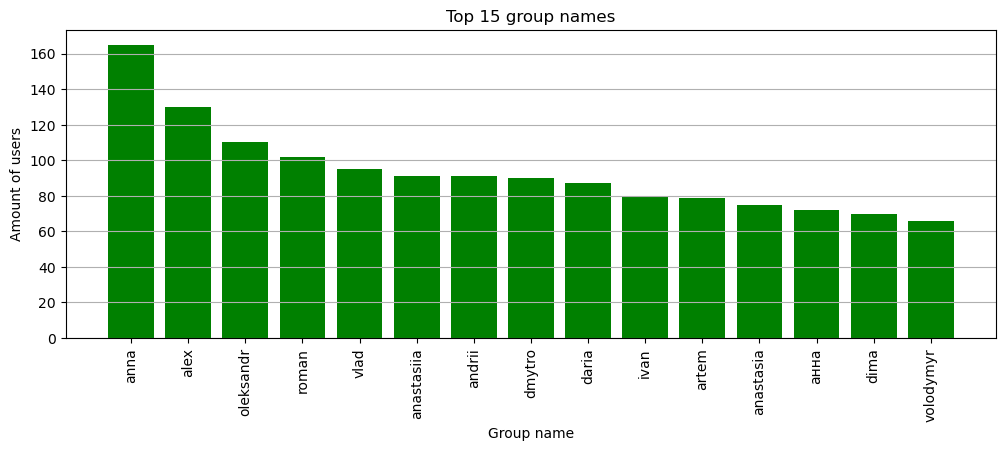

In [65]:
plt.subplots(figsize=(12,4))
plt.bar(existed_names_groups.head(15).index,existed_names_groups.head(15).values, color='g')

plt.xlabel('Group name')
plt.ylabel('Amount of users')
plt.title('Top 15 group names')
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.show()

After this I can identify by users formatted name the user's sex. And use this information further

In [66]:
# Identify user's sex
df_all_female_names = pd.concat([df_female_transcript_names,df_female_russian_names,df_female_ukrainian_names,df_new_female_names]).drop_duplicates().reset_index(drop=True)
df_all_male_names = pd.concat([df_male_transcript_names,df_male_russian_names,df_male_ukrainian_names,df_new_male_names]).drop_duplicates().reset_index(drop=True)

df_all_female_names['name'] = df_all_female_names.name.str.lower()
df_all_male_names['name'] = df_all_male_names.name.str.lower()


In [67]:
df_all_female_names

,name
0,elena
1,tatyana
2,natalia
3,olga
4,maria
...,...
6246,anzhela
6247,аnna
6248,yara
6249,катруся


In [68]:
# def process_sex(row):
#     if row.formatted_first_name in df_all_female_names['name']:
#         return 'f'
#     elif row.formatted_first_name in df_all_male_names['name']:
#         return 'm'
#     else:
#         return 'n'


df_users['sex'] = df_users.formatted_first_name.apply(lambda name: 'f' if name in df_all_female_names['name'].values else 'm' if name in df_all_male_names['name'].values else 'n' )




In [69]:
sex_groups = df_users.sex.value_counts()

Sex groups in TG

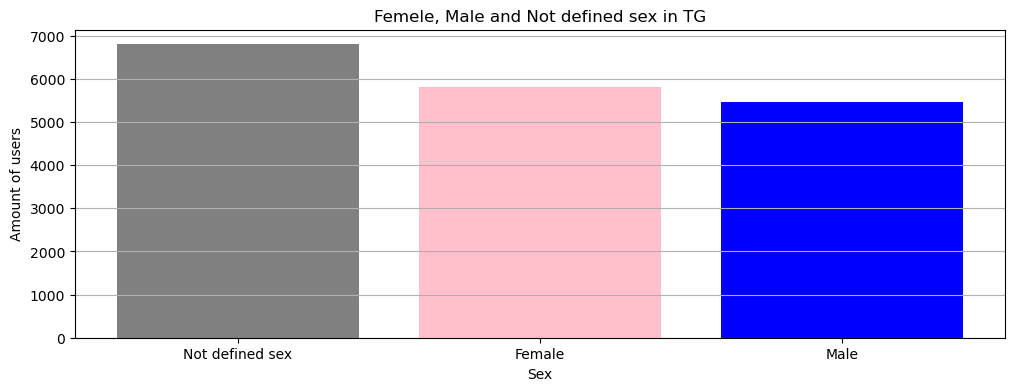

In [70]:
plt.subplots(figsize=(12,4))
plt.bar(sex_groups.rename(index={'n':'Not defined sex', 'f':'Female', 'm':'Male'}).index, sex_groups.values, color=['grey', 'pink', 'blue'])

plt.xlabel('Sex')
plt.ylabel('Amount of users')
plt.title('Femele, Male and Not defined sex in TG')
plt.grid(axis='y')
plt.show()

Intersting that my TG have more Female users than Male. Defining the sex of other users need more time and analyze.
This can be improved.

In [71]:
# Add information about sex and formatted first name to combined dataset
df_combined['_sex'] = df.from_id.apply(lambda _id: _id_to_col(_id, 'sex'))
df_combined['_formatted_first_name'] = df.from_id.apply(lambda _id: _id_to_col(_id, 'formatted_first_name'))

Then I decided to improve date formatting to define a day of the week and parse hour when message was sent

In [72]:
df_combined_female_sex = df_combined[df_combined['_sex'] == 'f']
df_combined_male_sex = df_combined[df_combined['_sex'] == 'm']
df_combined_none_sex = df_combined[df_combined['_sex'] == 'n']

In [73]:
# Prepared functions for statistic
def yearly(d):
    return d.year

def quarter(d):
    return datetime.datetime.strptime(f"{((d.month - 1 ) // 3 ) * 3 + 1}-{d.year}", "%m-%Y")

def monthly(d):
    return datetime.datetime.strptime(f'{d.month}/{d.year}', '%m/%Y')

def week_day(d):
    return d.day_name()

def daily(d):
    return d.strftime("%x")

def hour(d):
    return d.hour

In [74]:
def get_types_df(_df, _timeline):
    timelines = _df.date.apply(_timeline)
    timelines_all = timelines.value_counts().sort_index()
    timelines_types = _df.type.groupby(timelines).value_counts()
    return timelines_all, timelines_types

##### Amount of all messages sent Male vs Female vs None Defined per different timelines

In [75]:
def timeline_plt(timline_name, timeline_func, df_female_sex, df_male_sex, df_none_sex ):
    
    female_messages_timeline_all, female_messages_timeline_types = get_types_df(df_female_sex, timeline_func)
    male_messages_timeline_all,male_messages_timeline_types = get_types_df(df_male_sex, timeline_func)
    none_messages_timeline_all,none_messages_timeline_types = get_types_df(df_none_sex, timeline_func)

    fig, axes = plt.subplots(3,2,figsize=(15,10))

    axes[0][0].plot(female_messages_timeline_all.index, female_messages_timeline_all.values, label='Female', color='pink')
    axes[0][0].plot(male_messages_timeline_all.index, male_messages_timeline_all.values, label='Male', color='blue')
    axes[0][0].plot(none_messages_timeline_all.index, none_messages_timeline_all.values, label='None', color='grey')
    axes[0][0].set_title('All')
    axes[0][0].legend()

    axes[0][1].plot(female_messages_timeline_types[:,'text'].index, female_messages_timeline_types[:,'text'].values, label='Female', color='pink')
    axes[0][1].plot(male_messages_timeline_types[:,'text'].index, male_messages_timeline_types[:,'text'].values, label='Male', color='blue')
    axes[0][1].plot(none_messages_timeline_types[:,'text'].index, none_messages_timeline_types[:,'text'].values, label='None', color='grey')
    axes[0][1].set_title('Text Messages')
    axes[0][1].legend()
    
    axes[1][0].plot(female_messages_timeline_types[:,'sticker'].index, female_messages_timeline_types[:,'sticker'].values, label='Female', color='pink')
    axes[1][0].plot(male_messages_timeline_types[:,'sticker'].index, male_messages_timeline_types[:,'sticker'].values, label='Male', color='blue')
    axes[1][0].plot(none_messages_timeline_types[:,'sticker'].index, none_messages_timeline_types[:,'sticker'].values, label='None', color='grey')
    axes[1][0].set_title('Stickers')
    axes[1][0].legend()

    axes[1][1].plot(female_messages_timeline_types[:,'voice'].index, female_messages_timeline_types[:,'voice'].values, label='Female', color='pink')
    axes[1][1].plot(male_messages_timeline_types[:,'voice'].index, male_messages_timeline_types[:,'voice'].values, label='Male', color='blue')
    axes[1][1].plot(none_messages_timeline_types[:,'voice'].index, none_messages_timeline_types[:,'voice'].values, label='None', color='grey')
    axes[1][1].set_title('Voice messages')
    axes[1][1].legend()

    axes[2][0].plot(female_messages_timeline_types[:,'photo'].index, female_messages_timeline_types[:,'photo'].values, label='Female', color='pink')
    axes[2][0].plot(male_messages_timeline_types[:,'photo'].index, male_messages_timeline_types[:,'photo'].values, label='Male', color='blue')
    axes[2][0].plot(none_messages_timeline_types[:,'photo'].index, none_messages_timeline_types[:,'photo'].values, label='None', color='grey')
    axes[2][0].set_title('Photos')
    axes[2][0].legend()
    
    axes[2][1].plot(female_messages_timeline_types[:,'video'].index, female_messages_timeline_types[:,'video'].values, label='Female', color='pink')
    axes[2][1].plot(male_messages_timeline_types[:,'video'].index, male_messages_timeline_types[:,'video'].values, label='Male', color='blue')
    axes[2][1].plot(none_messages_timeline_types[:,'video'].index, none_messages_timeline_types[:,'video'].values, label='None', color='grey')
    axes[2][1].set_title('Videos')
    axes[2][1].legend()
   

    plt.legend()
    plt.suptitle(f'Messages per {timline_name.lower()}')
    
    plt.show()

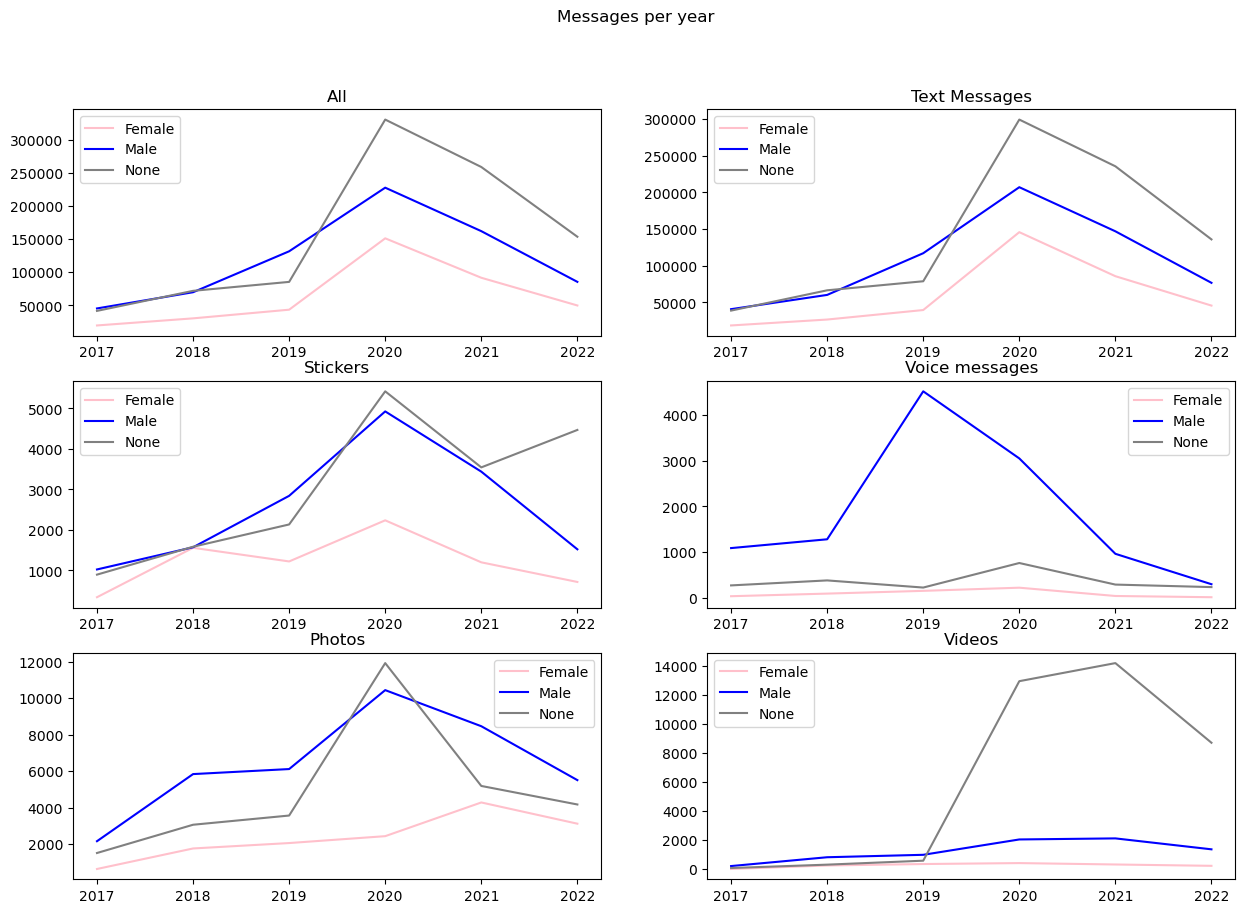

In [76]:
timeline_plt('Year', yearly, df_combined_female_sex, df_combined_male_sex, df_combined_none_sex )

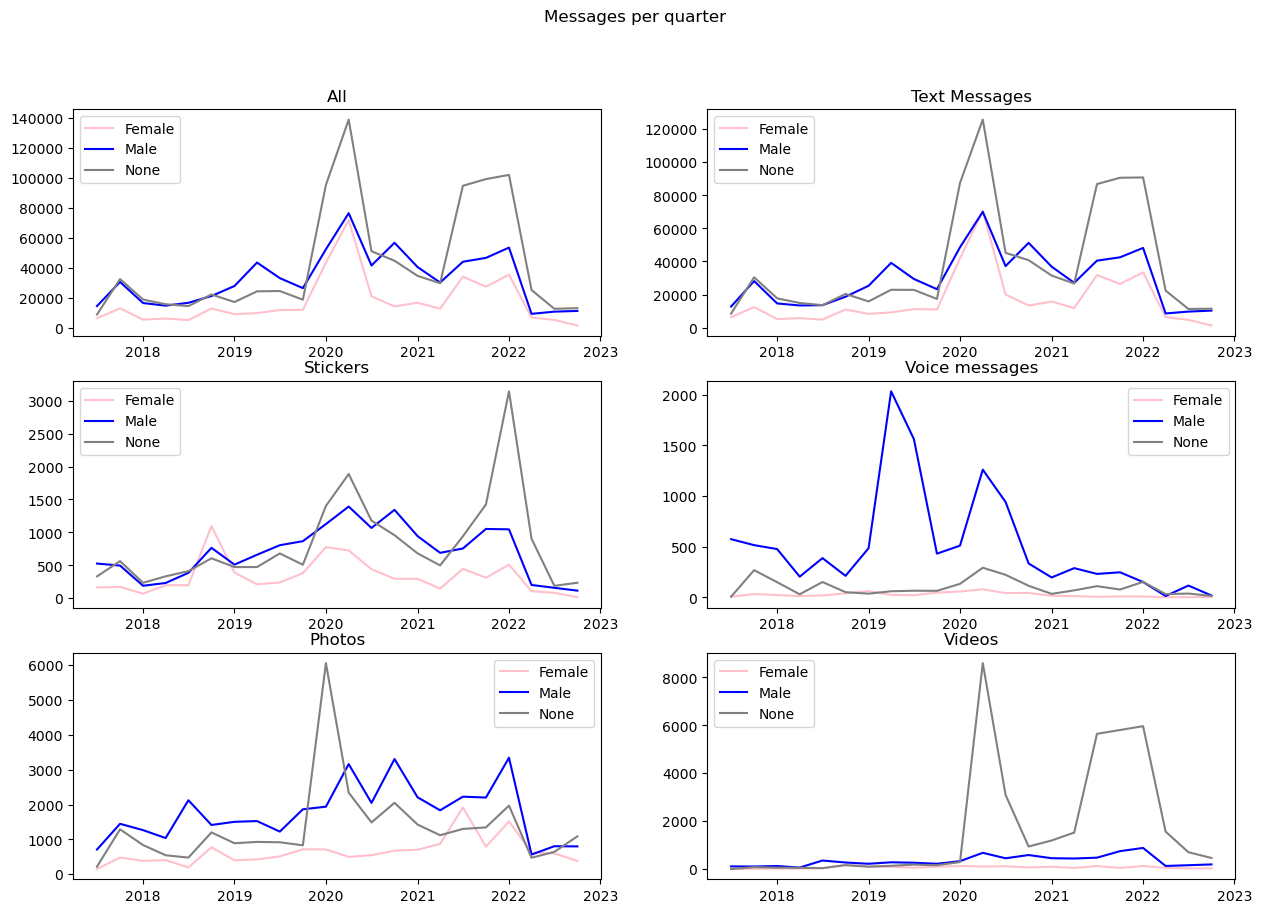

In [77]:
timeline_plt('Quarter', quarter, df_combined_female_sex, df_combined_male_sex, df_combined_none_sex )

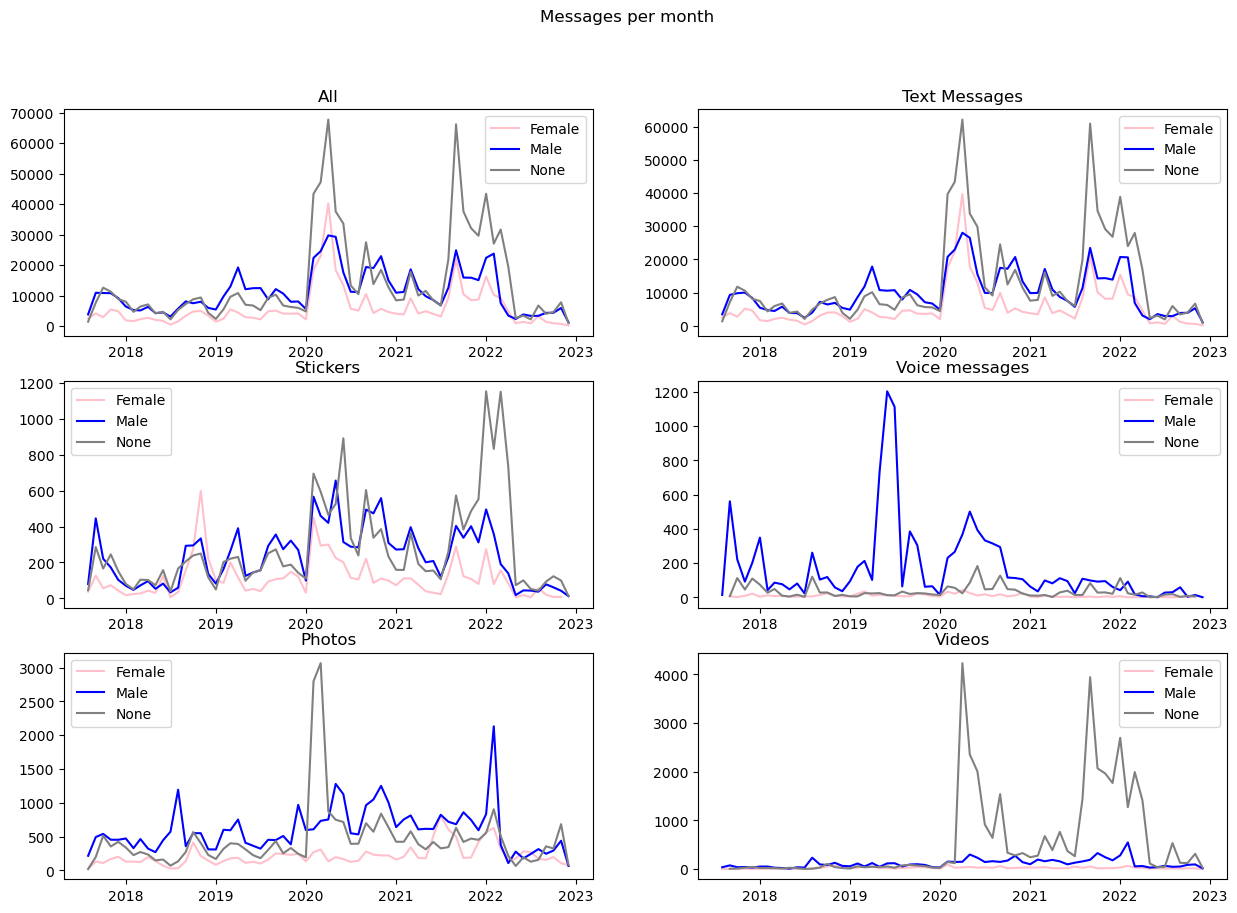

In [78]:
timeline_plt('Month', monthly, df_combined_female_sex, df_combined_male_sex, df_combined_none_sex )

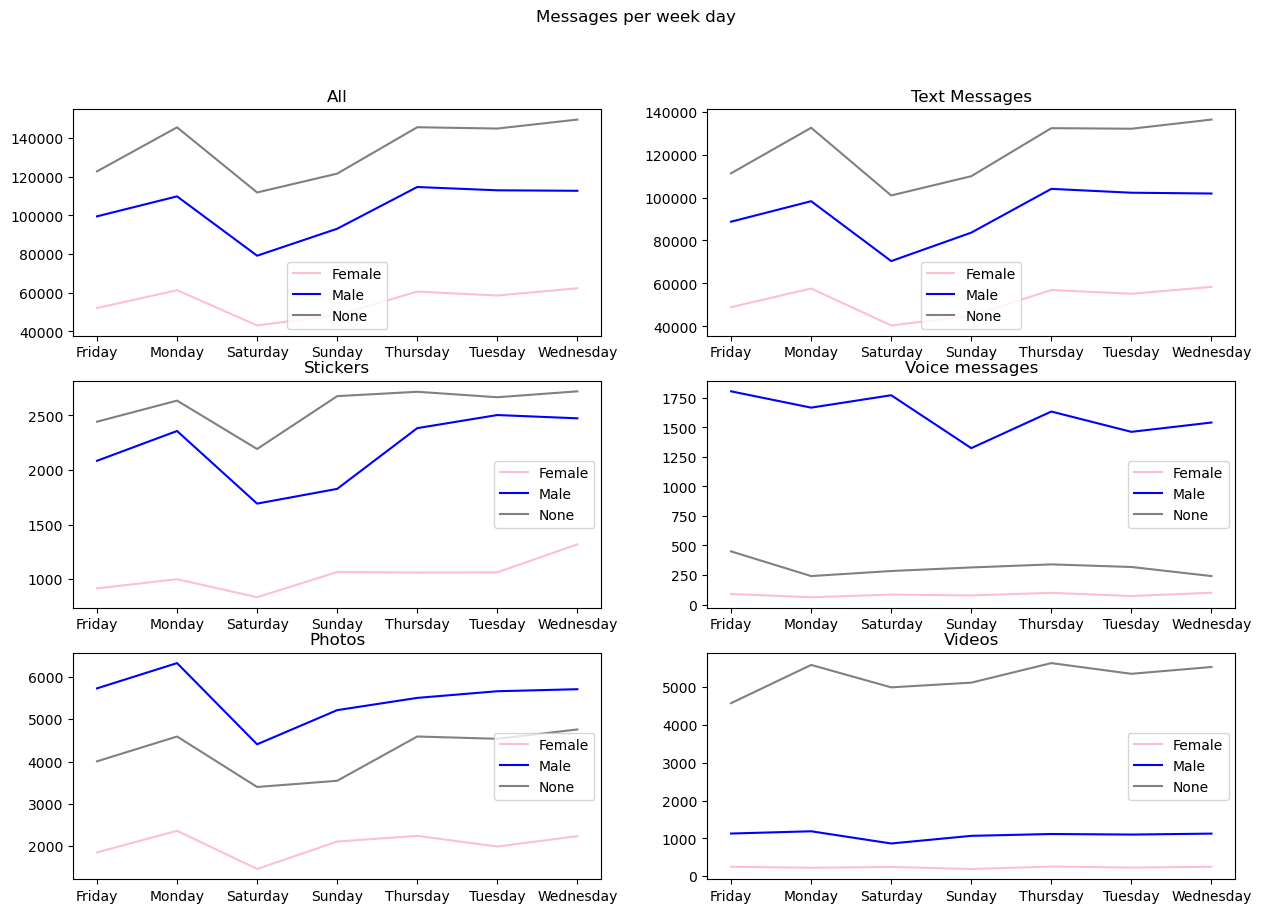

In [79]:
timeline_plt('Week day', week_day, df_combined_female_sex, df_combined_male_sex, df_combined_none_sex )

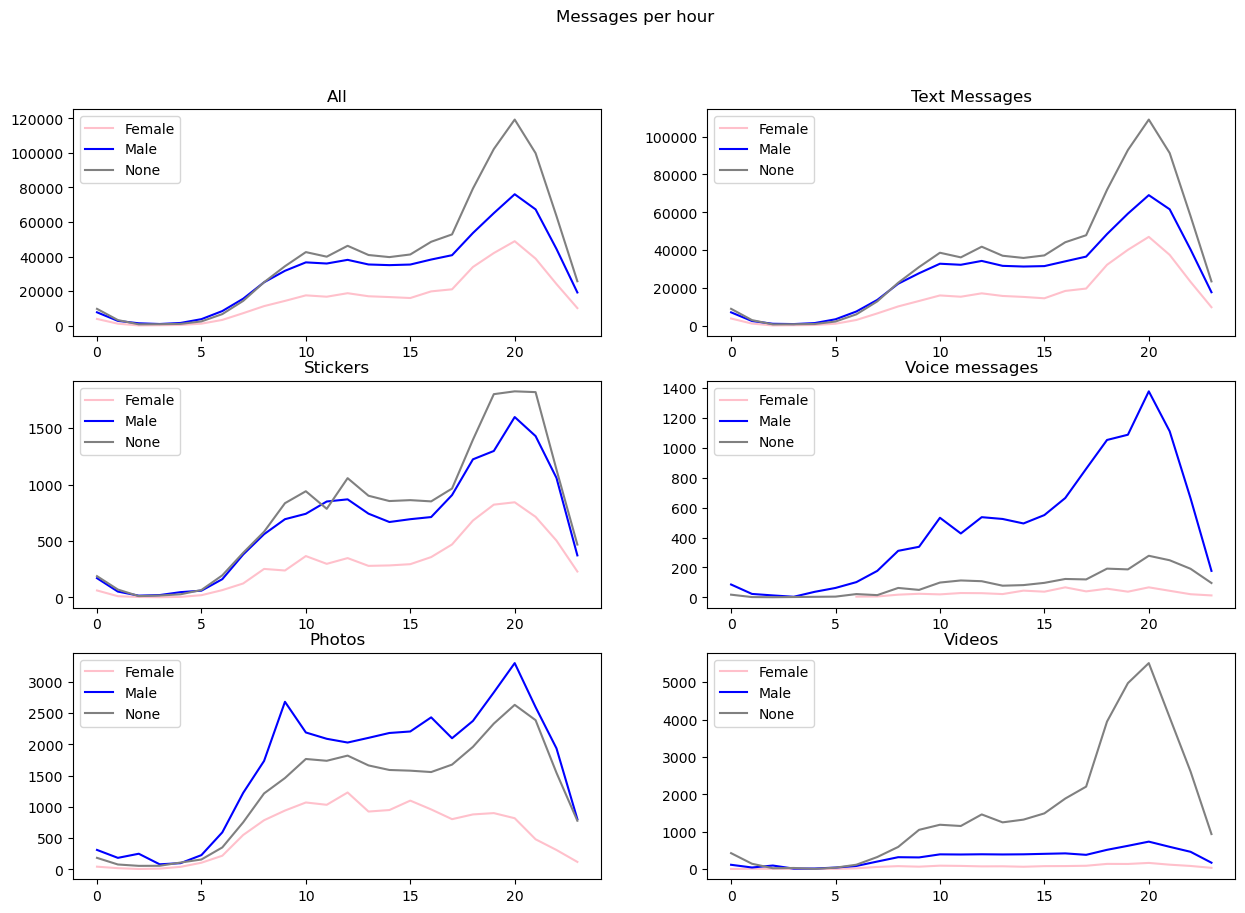

In [80]:
timeline_plt('Hour', hour, df_combined_female_sex, df_combined_male_sex, df_combined_none_sex )

Interesting that male users are more active than female. Male users send more voice messages and photos than female. Also it is noticable how undefined users, that can represent channels and group messages became active during phase of COVID-19 and full-scale invasion. Also interersting to see that all users are active about 8 pm every day and the most active on Monday

Than I decided to imrove word counter and use to find the popularity of COVID vaccines over the time.
And analyze the same information for different sex groups. Because different people can spell and write vaccines in different ways I decided to create list of synonyms.

In [81]:
def word_usage(word_list, _df, timeline_func):
    word_occur = _df.message.apply(lambda m: sum(m.lower().count(x) for x in word_list)).rename('wcount')
    usage = pd.concat([_df.date, word_occur], axis=1)
    _timeline = usage.date.apply(timeline_func)
    usage_grouped = usage.wcount.groupby(_timeline).sum() 
    usage_grouped.drop(usage_grouped.index.max(), inplace=True)
    return usage_grouped

In [82]:
def plot_word_usage_for_sex_groups(word, synonyms_list, timeline_func, df_female, df_male, df_none):
    usage_f = word_usage(synonyms_list, df_female, timeline_func)
    usage_m = word_usage(synonyms_list, df_male, timeline_func)
    usage_none = word_usage(synonyms_list, df_none, timeline_func)
    
    
    plt.subplots(figsize=(12,4))
    plot_line(x=usage_f.index, y=usage_f.values, xlabel='Date', ylabel='Occurrences', title=f'Usage of {word}', colour='pink')
    plot_line(x=usage_m.index, y=usage_m.values, colour='#1f77b4')
    plot_line(x=usage_none.index, y=usage_none.values, colour='grey')
    plt.grid(axis='y')
    plt.show()

In [83]:
vaccines = {
    'astrazeneca': {'full_name':'Astrazeneca','synonyms_list':['астразенек', 'астра-зенек', 'zenec','astraz']},
    'pfizer': {'full_name':'Pfizer','synonyms_list':['pfizer','пфайзер','файзер','комирнати','комірнаті','comirnaty','комернати','комернаті']},
    'coronovac': {'full_name':'Coronovac','synonyms_list':['coronovac','coronovak','короновак','коронавак','коронавок','coronavak','coronavac','sinovac','sinovak','sinovoc','sinovok','сіновак','сіновак','синовак','синавак']},
    'moderna': {'full_name':'Moderna','synonyms_list': ['moderna','maderna','мадерн','модерн']},
    'vaccine': {'full_name':'Vaccine', 'synonyms_list':['вакцин','прививка','vaccine','щепленн','шчеплення']}
}

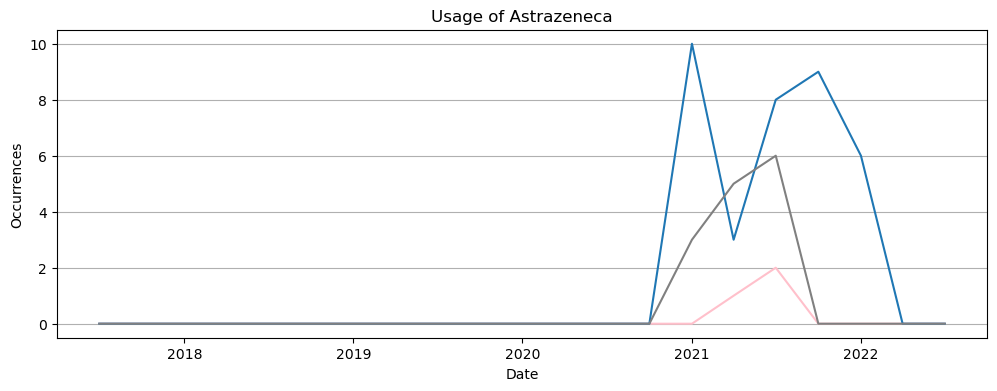

In [84]:
plot_word_usage_for_sex_groups(vaccines['astrazeneca']['full_name'], vaccines['astrazeneca']['synonyms_list'], quarter, df_combined_female_sex, df_combined_male_sex, df_combined_none_sex )

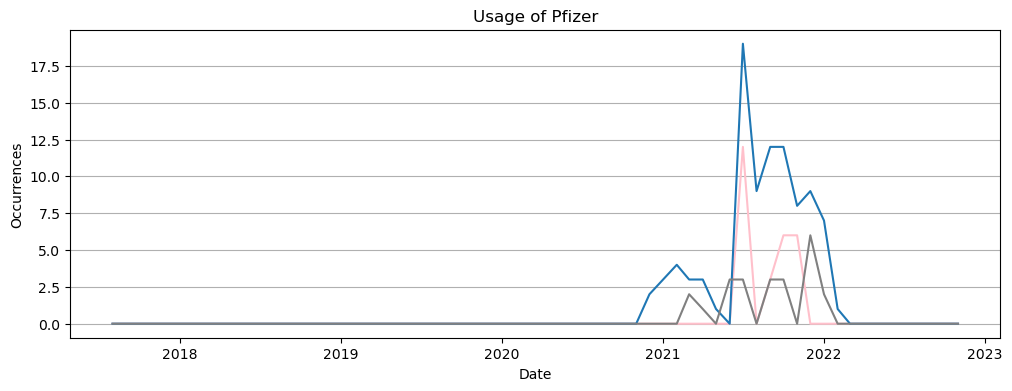

In [85]:
plot_word_usage_for_sex_groups(vaccines['pfizer']['full_name'], vaccines['pfizer']['synonyms_list'], monthly, df_combined_female_sex, df_combined_male_sex, df_combined_none_sex )

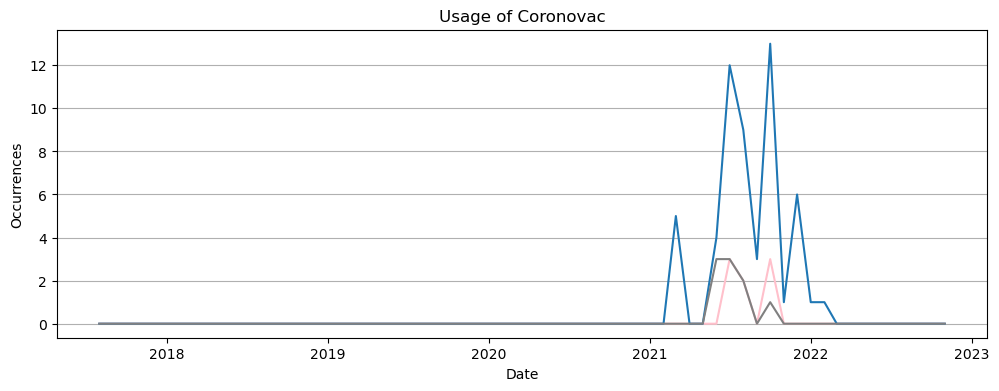

In [86]:
plot_word_usage_for_sex_groups(vaccines['coronovac']['full_name'], vaccines['coronovac']['synonyms_list'], monthly, df_combined_female_sex, df_combined_male_sex, df_combined_none_sex )

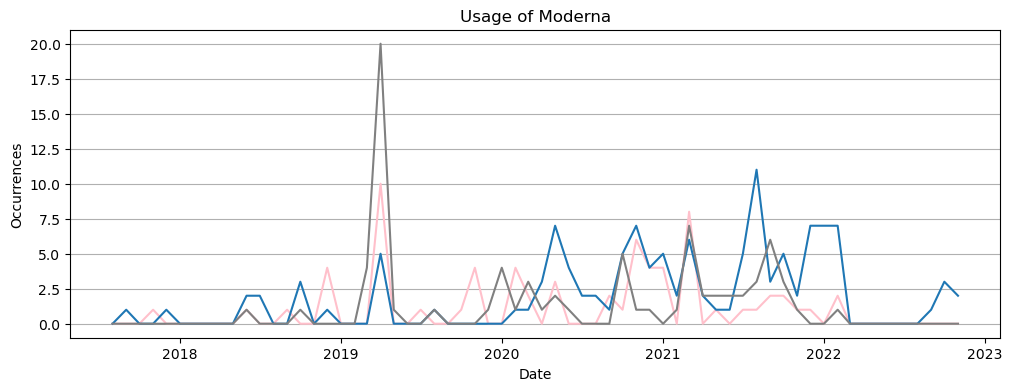

In [87]:
plot_word_usage_for_sex_groups(vaccines['moderna']['full_name'], vaccines['moderna']['synonyms_list'], monthly, df_combined_female_sex, df_combined_male_sex, df_combined_none_sex )

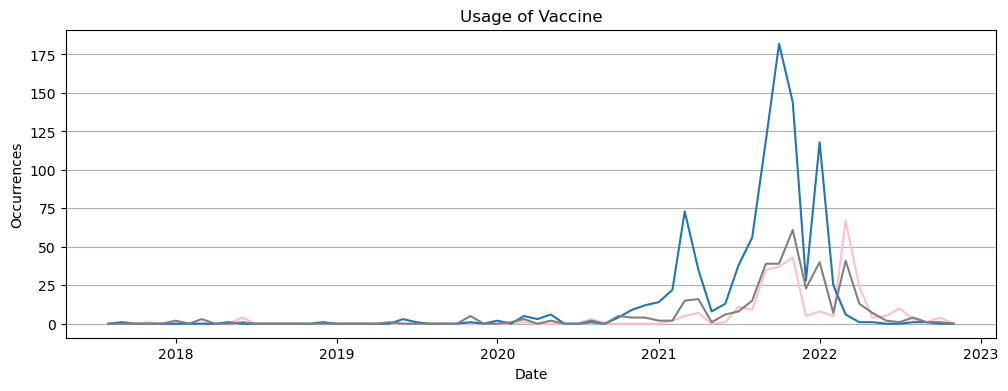

In [88]:
plot_word_usage_for_sex_groups(vaccines['vaccine']['full_name'], vaccines['vaccine']['synonyms_list'], monthly, df_combined_female_sex, df_combined_male_sex, df_combined_none_sex )

In [89]:
# https://ourworldindata.org/coronavirus/country/ukraine
df_owid_covid = pd.read_csv('./owid-covid-data.csv')

In [90]:
print(df_owid_covid.empty)
print(df_owid_covid.shape)
print(df_owid_covid.size)

False
(241511, 67)
16181237


In [91]:
df_owid_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241511 entries, 0 to 241510
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    241511 non-null  object 
 1   continent                                   227928 non-null  object 
 2   location                                    241511 non-null  object 
 3   date                                        241511 non-null  object 
 4   total_cases                                 227547 non-null  float64
 5   new_cases                                   227259 non-null  float64
 6   new_cases_smoothed                          226060 non-null  float64
 7   total_deaths                                208162 non-null  float64
 8   new_deaths                                  208094 non-null  float64
 9   new_deaths_smoothed                         206910 non-null  float64
 

In [92]:
df_owid_covid.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [93]:
df_owid_covid.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
241508,ZWE,Africa,Zimbabwe,2022-12-07,259356.0,NaN,NaN,5622.0,0.0,0.286,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
241509,ZWE,Africa,Zimbabwe,2022-12-08,259356.0,NaN,NaN,5622.0,0.0,0.286,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
241510,ZWE,Africa,Zimbabwe,2022-12-09,259356.0,NaN,NaN,5622.0,0.0,0.286,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN


In [94]:
df_covid_ukraine = df_owid_covid[df_owid_covid.location == 'Ukraine'].sort_values(by='date')

# formatted date for easier use
df_covid_ukraine.date = df_covid_ukraine.date.apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d' ))

In [95]:
%matplotlib notebook
import matplotlib.animation as ani

In [96]:
# prepare COVID-19 data
qaurters_deathes = df_covid_ukraine.date.apply(monthly)
covid_deathers_grouped = df_covid_ukraine.new_deaths.groupby(qaurters_deathes).sum()

In [97]:
# min 
covid_deathers_grouped.index.min()

Timestamp('2020-03-01 00:00:00')

In [98]:
all_vaccines = vaccines['moderna']['synonyms_list'] + vaccines['pfizer']['synonyms_list'] + vaccines['coronovac']['synonyms_list'] + vaccines['astrazeneca']['synonyms_list'] + vaccines['vaccine']['synonyms_list'] 

df_combined_female_sex_during_pandemi = df_combined_female_sex[df_combined_female_sex.date>'2020-03-01']
df_combined_male_sex_during_pandemi = df_combined_male_sex[df_combined_male_sex.date>'2020-03-01']
df_combined_all_during_pandemi = df_combined[df_combined.date>'2020-03-01']

#prepare TG data
usage_f = word_usage(all_vaccines, df_combined_female_sex_during_pandemi, monthly)
usage_m = word_usage(all_vaccines, df_combined_male_sex_during_pandemi, monthly)
usage_all = word_usage(all_vaccines, df_combined_all_during_pandemi, monthly)


<IPython.core.display.Javascript object>


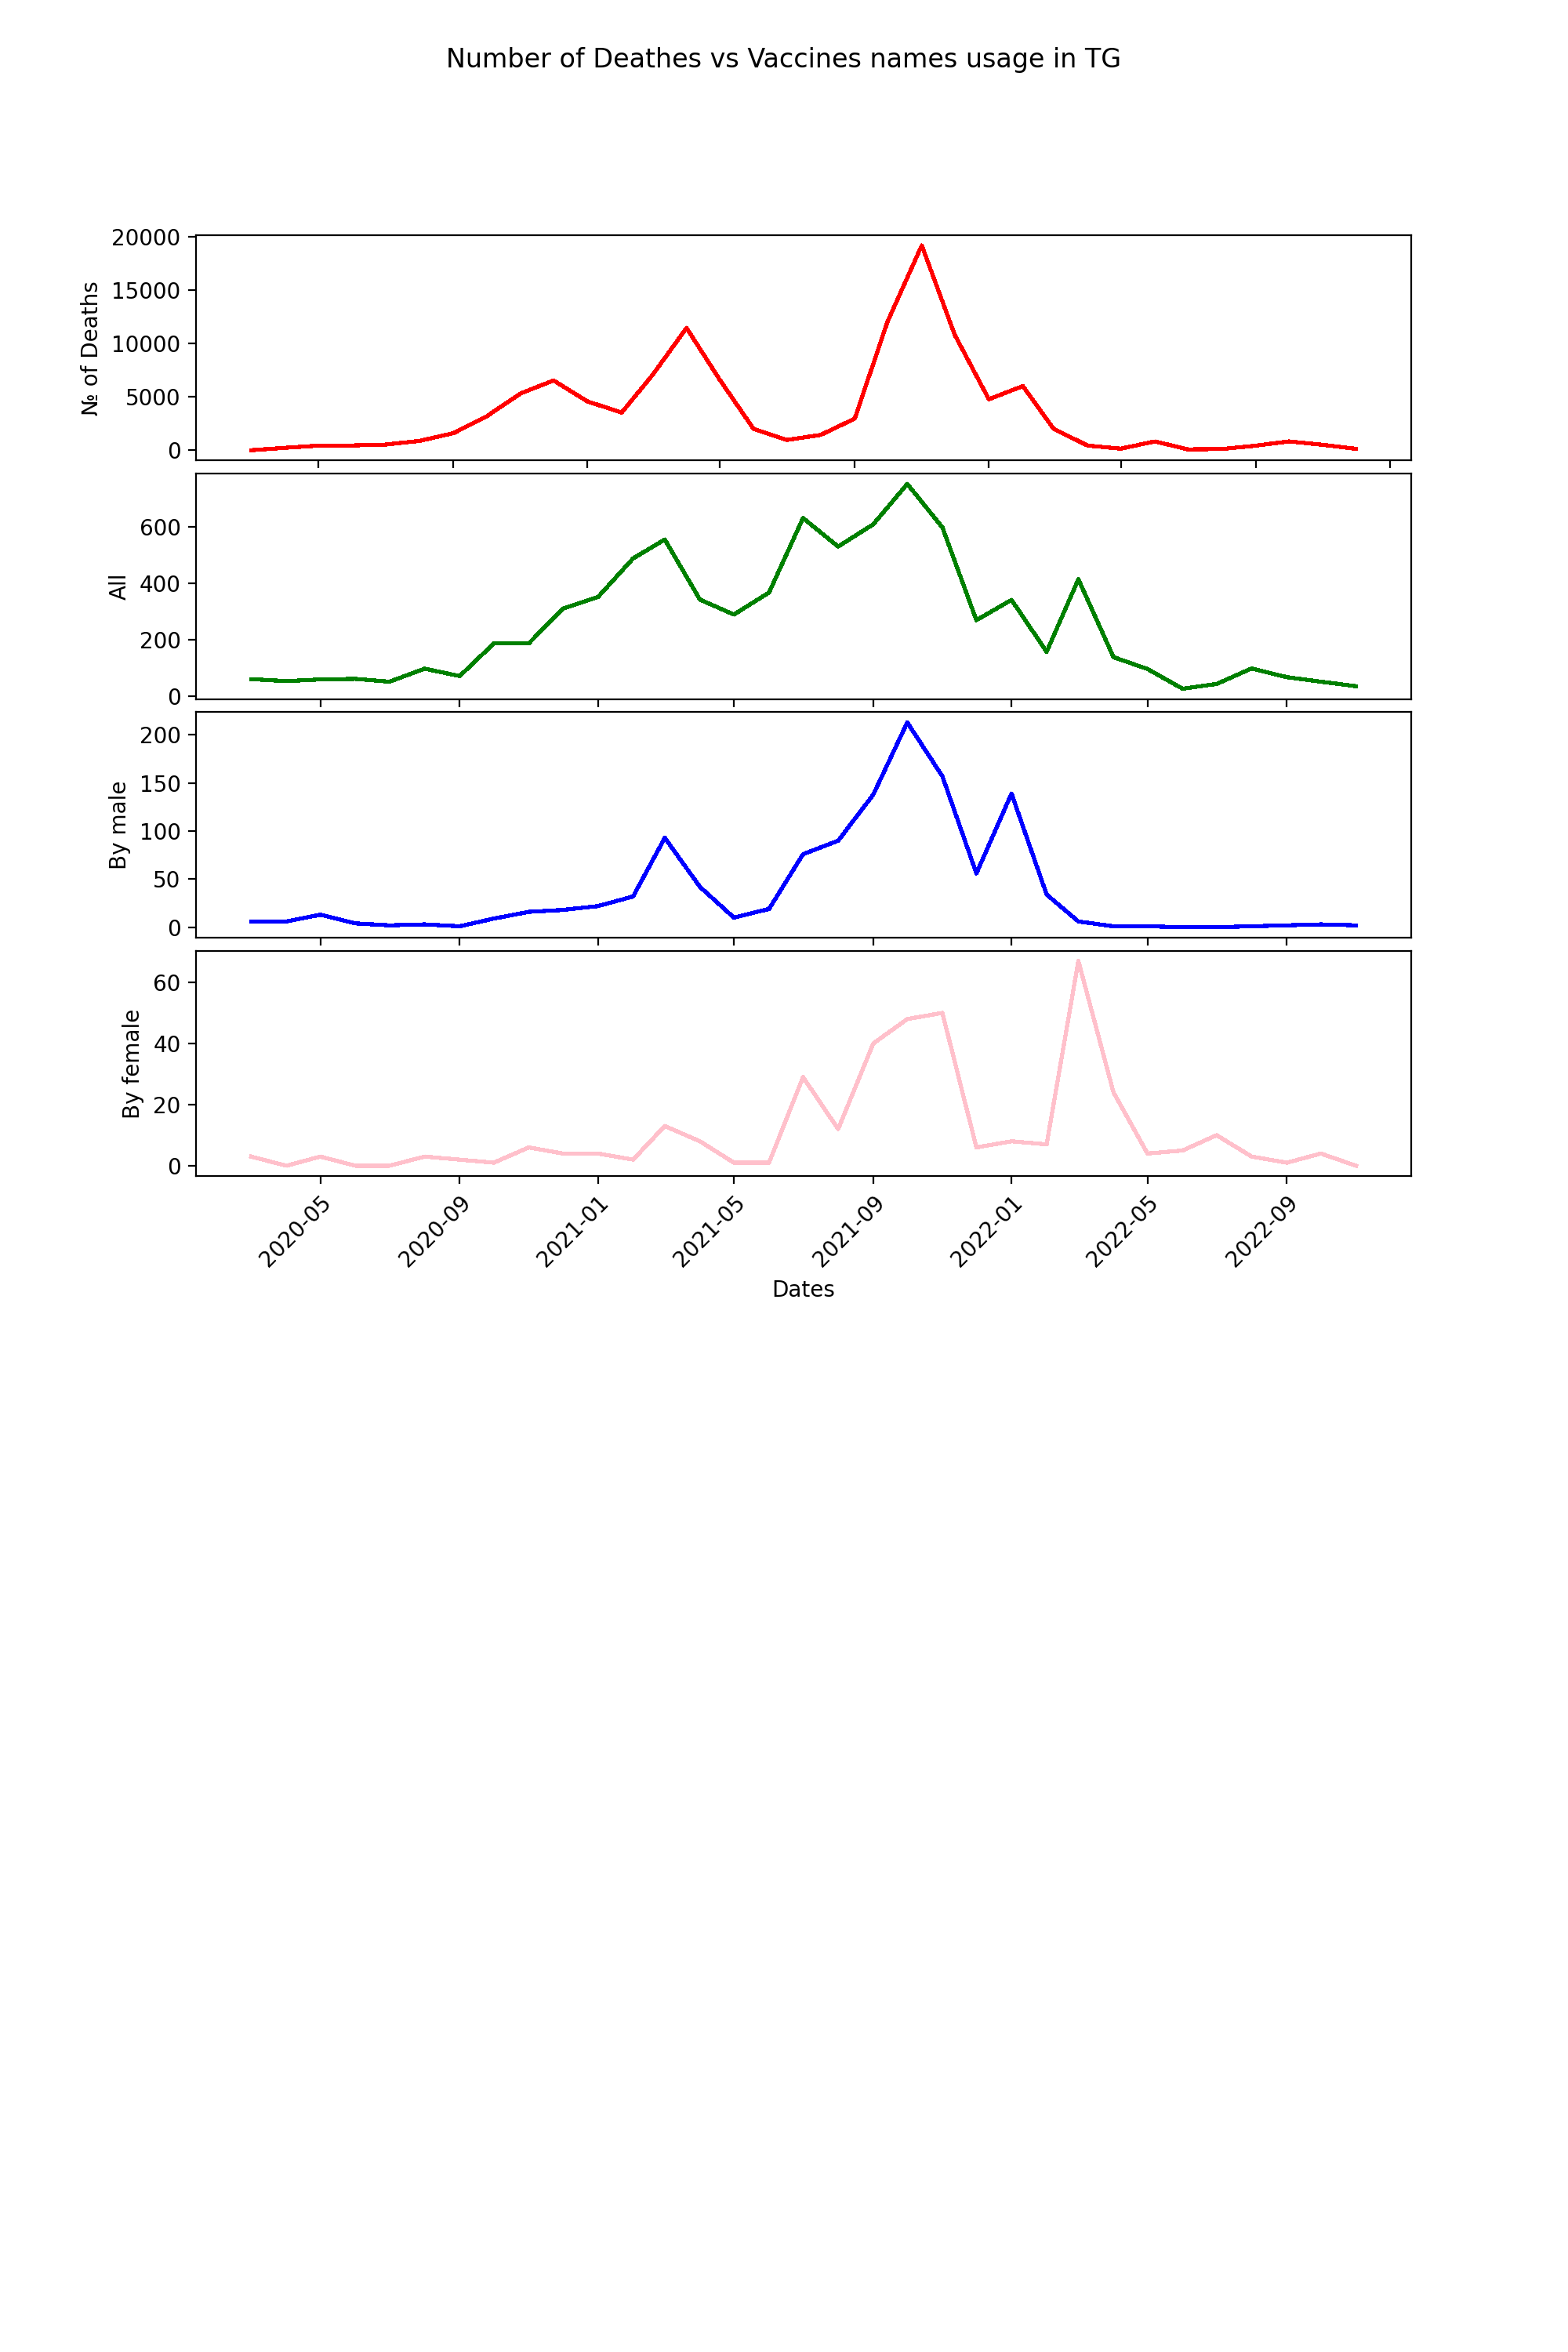

In [99]:
fig = plt.figure(figsize=(10,15))


def builddeathchart(i=int):
    plt.subplot(12, 2, (1,6))
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor") 
    plt.subplots_adjust(bottom = 0.5, top = 0.9) 
    plt.ylabel('№ of Deaths')
    plt.xlabel('Dates')
    plt.grid(axis='y')
    plt.plot(covid_deathers_grouped[:i].index, covid_deathers_grouped[:i].values, color='r') 
    
def buildwordusageall(i=int):
    plt.subplot(12, 2, (7,12))
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor") 
    plt.subplots_adjust(bottom = 0.5, top = 0.9) 
    plt.ylabel('All')
    plt.xlabel('Dates')
    plt.grid(axis='y')
    plt.plot(usage_all[:i].index, usage_all[:i].values, color='g')  
    
def buildwordusagefemale(i=int):
    plt.subplot(12, 2, (13,18))
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor") 
    plt.subplots_adjust(bottom = 0.5, top = 0.9) 
    plt.ylabel('By male')
    plt.xlabel('Dates')
    plt.grid(axis='y')
    plt.plot(usage_m[:i].index, usage_m[:i].values, color='blue')  
        
def buildwordusagemale(i=int):
    plt.subplot(12, 2, (19,24))
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor") 
    plt.subplots_adjust(bottom = 0.5, top = 0.9) 
    plt.ylabel('By female')
    plt.xlabel('Dates')
    plt.grid(axis='y')
    plt.plot(usage_f[:i].index, usage_f[:i].values, color='pink')  
    
animator1 = ani.FuncAnimation(fig, builddeathchart, interval = 300)
animator2 = ani.FuncAnimation(fig, buildwordusageall, interval = 300)
animator3 = ani.FuncAnimation(fig, buildwordusagefemale, interval = 300)
animator4 = ani.FuncAnimation(fig, buildwordusagemale, interval = 300)

plt.suptitle('Number of Deathes vs Vaccines names usage in TG')
plt.show()

It is noticable how the usage of vaccines words was inreasing when we had a big amount of deaths. Male users were writing more about vaccines than female users.